積極的に小さい関数を作り、テストをしやすくする。

In [64]:
import numpy as np
import math


def TIP4PSites():
    """
    TIP4Pの座標系
    """

    angle,holen,colen = 104.52,0.9572,0.15
    wh = 1.0
    wo = 16.0
    wm = wh + wh + wo
    rangle = angle*math.pi/360
    ohz=holen*math.cos(rangle)
    hyl=holen*math.sin(rangle)
    hzl=wo*ohz/wm
    ol=-ohz+hzl
    cl=colen+ol

    # 分子内の原子位置
    return np.array([[0,hyl,hzl],
                      [0,-hyl,hzl],
                      [0,0,ol],
                      [0,0,cl]]).T, np.array([wh,wh,wo,0.0])


In [65]:
# 分子の座標を読みこむ。
def LoadNX3A(file):
    # file = open("9.nx3a")
    while True:
        line = file.readline()
        if len(line) == 0:
            break
        if "@NX3A" in line:
            line = file.readline()
            nmol = int(line)
            pos = []
            for i in range(nmol):
                line = file.readline()
                pos.append([float(x) for x in line.split()])
            pos = np.array(pos)
        if "@BOX3" in line:
            line = file.readline()
            cell = np.diag(np.array([float(x) for x in line.split()]))
    return cell, pos



In [66]:
#import importlib
#importlib.reload(Symbolic)
from Symbolic import phic, phic_r, phic_rr, phiLJ, phiLJ_r, phiLJ_rr, Trunc, Trunc_r, Trunc_rr, A, Aa, Ab, Ac, Aaa, Aab, Aca, Abb, Abc, Acc, KETensor

In [67]:
# 回転行列とその微分の値を算出する。
# 分子は動かないので、回転行列もその微分も定数である。



#for i in range(nmol):
#    for j in range(i):
#        print("distance {0}-{1}".format(i,j))
#        print(np.linalg.norm(pos[i][0:3]-pos[j][0:3]))

def dSite(euler, intra):

    def conv_euler(ea,eb,ec):
        sina=math.sin(ea)
        sinb=math.sin(eb)
        sinc=math.sin(ec)
        cosa=math.cos(ea)
        cosb=math.cos(eb)
        cosc=math.cos(ec)

        ap = math.acos(sina*sinc)
        cp = math.atan2(sina*cosc, cosa)
        bp = math.atan2(-sinb*sinc*cosa+cosb*cosc, -sinb*cosc-sinc*cosa*cosb)
        return ap,bp,cp

    # 分子内座標の、軸を交換したもの
    intra2 = np.zeros_like(intra)
    intra2[0] = intra[1]
    intra2[1] = intra[2]
    intra2[2] = intra[0]   
    nmol = pos.shape[0]
    # 回転行列に分子内座標をかけたもの。原子の重心からの空間座標
    D0 = np.zeros([nmol,3,4])
    # 回転行列の、角度による一階微分に、分子内座標をかけたもの。
    # D1 == dR_i / da_i
    D1 = np.zeros([nmol,3,3,4]) # molecule, euler angle, vectors, sites
    # 回転行列の、角度による二階微分に、分子内座標をかけたもの。
    # D2 == d^2 R_i / da db
    D2 = np.zeros([nmol,3,3,3,4]) # molecule, euler angle1, angle2, vectors, sites

    # Euler角が特異点に近付く場合には、分子内座標をとりなおし、それにあわせて角度も再計算する。
    lc = np.zeros(nmol, dtype=int)

    for i in range(nmol):
        ea,eb,ec = euler[i]
        # print("criteria", abs(math.sin(ea)))
        if abs(math.sin(ea)) > 1.0:
            # 第一回転規約
            D0[i]     = A(ea,eb,ec) @ intra
            D1[i,0]   = Aa(ea,eb,ec) @ intra
            D1[i,1]   = Ab(ea,eb,ec) @ intra
            D1[i,2]   = Ac(ea,eb,ec) @ intra
            D2[i,0,0] = Aaa(ea,eb,ec) @ intra
            D2[i,1,1] = Abb(ea,eb,ec) @ intra
            D2[i,2,2] = Acc(ea,eb,ec) @ intra
            D2[i,0,1] = Aab(ea,eb,ec) @ intra
            D2[i,1,2] = Abc(ea,eb,ec) @ intra
            D2[i,2,0] = Aca(ea,eb,ec) @ intra
            D2[i,1,0] = D2[i,0,1]
            D2[i,2,1] = D2[i,1,2]
            D2[i,0,2] = D2[i,2,0]
        else:
            # 第二回転規約
            ea,eb,ec = conv_euler(ea,eb,ec)
            pos[i][3:6] = ea,eb,ec
            lc[i]     = 1 # rotation order of second kind
            D0[i]     = A(ea,eb,ec) @ intra2
            D1[i,0]   = Aa(ea,eb,ec) @ intra2
            D1[i,1]   = Ab(ea,eb,ec) @ intra2
            D1[i,2]   = Ac(ea,eb,ec) @ intra2
            D2[i,0,0] = Aaa(ea,eb,ec) @ intra2
            D2[i,1,1] = Abb(ea,eb,ec) @ intra2
            D2[i,2,2] = Acc(ea,eb,ec) @ intra2
            D2[i,0,1] = Aab(ea,eb,ec) @ intra2
            D2[i,1,2] = Abc(ea,eb,ec) @ intra2
            D2[i,2,0] = Aca(ea,eb,ec) @ intra2
            D2[i,1,0] = D2[i,0,1]
            D2[i,2,1] = D2[i,1,2]
            D2[i,0,2] = D2[i,2,0]
    return lc, D0, D1, D2

In [68]:
intra, mass = TIP4PSites()
# for a rigid rotor
IM = np.array([mass @ np.sum(intra[1:3]**2, axis=0),
               mass @ np.sum(intra[0:3:2]**2, axis=0),
               mass @ np.sum(intra[0:2]**2, axis=0)])
file = open("test.nx3a")
cell, pos = LoadNX3A(file)
lc, D0, D1, D2 = dSite(pos[:,3:6], intra)

# Tanaka programでの配列要素(1,2)は、Pythonでは[0,1]になる。
# 以後、縦横を精査。

In [69]:
lc

array([1, 1])

In [70]:
# 相互作用と分子形状に関するブロック


# 当面、田中プログラムとの照合のために、エネルギーの単位は、
# 水素2原子が1 Aにいる時のCoulomb力を1とする。

# SI unit 2019
Na=6.02214076e23
ee=1.60217662e-19
E0=8.8541878128e-12
UJ = 4.184
qe0 = ee**2/(4*math.pi*E0)*Na/UJ*1e7
qeT = 332.17752e0
sw = (qeT*UJ*1e6/18.0)**0.5/(6.0*math.pi)
# Tanaka's Units
TanakaScale = qeT / qe0
TokJmol = ee**2/(4*math.pi*E0*1e-7)*Na*TanakaScale
print("TanakaScale", TanakaScale)


charge = [0.52,0.52,0,-1.04]
LJpairs = {(2, 2):(6.0e5*UJ / TokJmol, 6.10e2*UJ / TokJmol)}
CCpairs = dict()
for i,ci in enumerate(charge):
    for j,cj in enumerate(charge):
        cc = ci*cj
        if cc:
            CCpairs[i,j] = cc
            


TanakaScale 1.0003427429781058


In [71]:
# 相互作用をサイト間距離で微分したもの。
# この辞書がNUMBAとフィットしない。もうすこし方法はないものか。
# 相対位置ベクトルと、関数の微分値を別の配列にしてしまう、か。

def derivatives(CCpairs, LJpairs, v, D0i, D0j):
    imax = 0
    jmax = 0
    for i, j in CCpairs:
        imax = max(i, imax)
        jmax = max(j, jmax)
    imax += 1
    jmax += 1
    ints = np.zeros([imax, jmax], dtype=bool)
    phis = np.zeros([imax, jmax, 3])
    seps = np.zeros([imax, jmax, 3])
    
    for (i,j),cc in CCpairs.items():
        ints[i,j] = True
        r         = D0i[:,i] - D0j[:,j] + v
        seps[i,j] = r
        rL = np.linalg.norm(r)
        phi    = cc*phic(rL)
        phi_r  = cc*phic_r(rL)
        phi_rr = cc*phic_rr(rL)
        phis[i,j] += np.array([phi, phi_r, phi_rr])

    for (i,j),(a1,a2) in LJpairs.items():
        ints[i,j] = True
        r         = D0i[:,i] - D0j[:,j] + v
        seps[i,j] = r
        rL = np.linalg.norm(r)
        phi    = phiLJ(rL,a1,a2)
        phi_r  = phiLJ_r(rL,a1,a2)
        phi_rr = phiLJ_rr(rL,a1,a2)
        phis[i,j] += np.array([phi, phi_r, phi_rr])

    return ints,seps,phis


In [72]:
def E_pair(ints, phis, ramp):
    """
    
    Args:
        ints (2nd rank numpy array of boolean): Pairs of interaction.
        phis (3rd rank numpy array of float:    Interaction and its derivatives
        ramp (float) : Ramp function
    """
    return ramp * np.sum(phis[ints, 0]) # 0th is interaction
    # return ramp * np.sum(phis[:,:,0]) # 0th is interaction

In [73]:
# 距離に関する関数を、相対ベクトルで微分する。

# from numba import jit

# @jit(nopython=True)
def di(r, f_r):
    """
    粒子i,jの距離r = |r_i - r_j|の関数f(r)を、iの位置ベクトルr_iで一階微分する。
    f_r,は距離での一階微分
    答は3-ベクトル
    """
    return f_r*(r/np.linalg.norm(r))

In [74]:
# 距離に関する関数を、相対ベクトルで二階微分する。

# このあたりの関数も、できればsympyに生成させたい。
# @jit(nopython=True)
def dxixi(r, f_r, f_rr):
    # r is a vector
    rL2 = r@r
    rL = rL2**0.5
    return f_r*(1 - r**2 / rL2) / rL + f_rr*r**2 / rL2

# @jit(nopython=True)
def dxiyi(r, f_r, f_rr):
    # r is a vector
    rL2 = r@r
    rL = rL2**0.5
    yz = -f_r*r[1]*r[2]/(rL2*rL) + f_rr*r[1]*r[2]/rL2
    zx = -f_r*r[2]*r[0]/(rL2*rL) + f_rr*r[2]*r[0]/rL2
    xy = -f_r*r[0]*r[1]/(rL2*rL) + f_rr*r[0]*r[1]/rL2
    return yz,zx,xy

# @jit(nopython=True)
def dii(r, f_r, f_rr):
    """
    粒子i,jの距離r = |r_i - r_j|の関数f(r)を、iの位置ベクトルr_iで二階微分する。
    f_r, f_rrは距離での一階、二階微分
    答は3x3行列。
    """
    vxx,vyy,vzz = dxixi(r, f_r, f_rr)
    vyz,vzx,vxy = dxiyi(r, f_r, f_rr)
    return np.array([[vxx,vxy,vzx],
                     [vxy,vyy,vyz],
                     [vzx,vyz,vzz]])


## Quenching

まず力を算出する。

### 変位の与え方

Overdamped motionとは、慣性的な動きが摩擦によっていつも打ち消され、常に力の方向に力に比例して進む状態と考えればいい。
加速度は(力/質量)に比例する。速度は加速度の分だけ増えるが、もともと速度が0であれば、速度もまた加速度に比例する。
力に比例して質点を動かすと、自然にエネルギーの極小に落ちこむ。

### 並進運動

$$\mathbf{F} = -{\partial \phi\over \partial \mathbf{r}}$$
この力により、通常の運動方程式であれば、分子は加速度を得るが、Quenchの場合はそれを速度に読みかえる。
${\mathbf{F}\over m}$に比例して並進させる。

In [75]:
def Force(pos, cell, Rin, Transition):
    nmol = pos.shape[0]
    celli = np.linalg.inv(cell)
    force = np.zeros([nmol,3])
    ep = 0.0
    for im in range(nmol):
        for jm in range(im+1,nmol):
            # 重心間相対ベクトル
            v = pos[im][:3] - pos[jm][:3]
            # 周期境界条件
            v -= cell @ np.floor( celli @ v + 0.5 )
            # 重心間距離
            vL = np.linalg.norm(v)
            # print("vL",vL)

            # 切断関数を準備。
            trunc = False
            if vL > Rin + Transition:
                # 遠すぎる対はパス
                continue
            if vL > Rin:
                # カットオフ関数がかかる場合
                ramp = Trunc(vL, Rin, Transition)
                ramp_r = Trunc_r(vL, Rin, Transition)
                ramp_rr = Trunc_rr(vL, Rin, Transition)
                # Tのvによる一階微分(ベクトル)
                Tv = di(v, ramp_r)
                # Truncのvによる二階微分(テンソル)
                Tvv = dii(v, ramp_r, ramp_rr)
                trunc = v, vL, ramp, ramp_r, ramp_rr, Tv, Tvv
            else:
                # 近距離
                ramp = 1.0
                ramp_r = 0.0
                ramp_rr = 0.0
                Tv = None
                Tvv = None
            ints, seps, phis = derivatives(CCpairs, LJpairs, v, D0[im], D0[jm])

            ep += E_pair(ints, phis, ramp)

            for si,sj in zip(*np.where(ints)):
                r = seps[si,sj]
                phi, phi_r, phi_rr = phis[si,sj]
                # cutoffは考えていない。
                rL = np.linalg.norm(r)
                F = -phi_r * r / rL
                force[im] += F
                force[jm] -= F
    return force, ep
        
force, ep = Force(pos, cell, Rin=6.5, Transition=2.0)
        

In [81]:
lastep = 99
ee = abs((lastep - ep) / ep)
wm = np.sum(mass)
nmol = pos.shape[0]
count = 0
nextshow = 1

while ee > 1e-8:
    # 本来、力を質量で割ったものは加速度だが、それを速度に読みかえる。
    v = (force/wm)*1.0
    pos[:,:3] += v*20.0
    lastep = ep
    force, ep = Force(pos, cell, Rin=6.5, Transition=2.0)
    ee = abs((lastep - ep) / ep)
    if count == nextshow:
        print("{0} energy (kJ/mol)={1}".format(count,ep*TokJmol/nmol))
        nextshow *= 2
    count += 1

print("{0} energy (kJ/mol)={1}".format(count,ep*TokJmol/nmol))



1 energy (kJ/mol)=-7.581940897584123


### 回転運動

Overdamped motionでは速度も角速度もいつも0とみなして構わない。そうすると、剛体軸周りの角加速度は、剛体軸周りのトルクを、その軸周りの慣性モーメントで割って得られる。(Goldstein 5-39')

トルクはベクトルで表される。

1. 質点の相互作用からトルクを計算
2. それを剛体座標に変換
3. 角加速度を求める
4. 回転行列の微小変化を求める
5. そして新しい配置でまた相互作用を計算する。

こんな手順か。

In [82]:
def Torque(pos, cell, R, Rin, Transition):
    nmol = pos.shape[0]
    celli = np.linalg.inv(cell)
    torque = np.zeros([nmol,3])
    for im in range(nmol):
        for jm in range(im+1,nmol):
            # 重心間相対ベクトル
            v = pos[im][:3] - pos[jm][:3]
            # 周期境界条件
            v -= cell @ np.floor( celli @ v + 0.5 )
            # 重心間距離
            vL = np.linalg.norm(v)
            # print("vL",vL)

            # 切断関数を準備。
            trunc = False
            if vL > Rin + Transition:
                # 遠すぎる対はパス
                continue
            if vL > Rin:
                # カットオフ関数がかかる場合
                ramp = Trunc(vL, Rin, Transition)
                ramp_r = Trunc_r(vL, Rin, Transition)
                ramp_rr = Trunc_rr(vL, Rin, Transition)
                # Tのvによる一階微分(ベクトル)
                Tv = di(v, ramp_r)
                # Truncのvによる二階微分(テンソル)
                Tvv = dii(v, ramp_r, ramp_rr)
                trunc = v, vL, ramp, ramp_r, ramp_rr, Tv, Tvv
            else:
                # 近距離
                ramp = 1.0
                ramp_r = 0.0
                ramp_rr = 0.0
                Tv = None
                Tvv = None
            ints, seps, phis = derivatives(CCpairs, LJpairs, v, D0[im], D0[jm])

            ep += E_pair(ints, phis, ramp)

            for si,sj in zip(*np.where(ints)):
                r = seps[si,sj]
                phi, phi_r, phi_rr = phis[si,sj]
                rL = np.linalg.norm(r)
                F = -phi_r * r / rL
                torque[im] += np.cross(D0[im,:,si], F)
                torque[jm] += np.cross(D0[jm,:,sj], -F)
    return torque, ep

# あらかじめ行列を準備しておく。これをアップデートする。
nmol = pos.shape[0]
R = np.zeros([nmol,3,3])
for im in range(nmol):
    ea, eb, ec = pos[im, 3:6]
    R[im] = A(ea,eb,ec)

torque, ep = Force(pos, cell, R, Rin=6.5, Transition=2.0)


        

In [84]:
lastep = 99
ee = abs((lastep - ep) / ep)
nmol = pos.shape[0]
count = 0
nextshow = 1

while ee > 1e-8:
    for im in range(nmol):
        # 分子内座標での慣性テンソル
        if lc[im] == 0:
            Ii = IM
        else:
            Ii = np.zeros(3)
            Ii[0] = IM[1]
            Ii[1] = IM[2]
            Ii[2] = IM[0]   
        # torqueはベクトルで表現される。
        # 空間座標でのtorqueを剛体座標になおす。
        ea,eb,ec = pos[im, 3:6]
        tm = A(ea,eb,ec).T @ torque[im]
        # 本来、Torqueを慣性モーメントで割ったものは角加速度だが、それを角速度に読みかえる。
        omega = tm / Ii
        print(omega)
    break
    lastep = ep
    force, ep = Force(pos, cell, Rin=6.5, Transition=2.0)
    ee = abs((lastep - ep) / ep)
    if count == nextshow:
        print("{0} energy (kJ/mol)={1}".format(count,ep*TokJmol/nmol))
        nextshow *= 2
    count += 1

print("{0} energy (kJ/mol)={1}".format(count,ep*TokJmol/nmol))



[-4.66153162e-06 -4.41017687e-06  1.78592808e-06]
[-8.87564237e-06 -3.28078178e-06  1.08192291e-09]
0 energy (kJ/mol)=-7.581940897584123


## Hessian

Hessianは、全相互作用$E_p=\sum_{i,j}^N \phi$を座標変数(剛体の場合は重心位置とEuler角の6変数のベクトル)$\mathbf{q}$で二階微分したもの。
実際の相互作用は、重心間ではなく、サイト間(原子間)で定義されるので、微分はこみいったものになる。

全相互作用が、分子間相互作用の総和で書ける場合は、ヘシアンも分子間に分解できる。

$$E_p=\sum_{i,j}^N \phi(i,j)$$
$$H=\sum_{i,j}^N{\partial^2 \phi\over \partial\mathbf{q}\partial\mathbf{q'}}=\sum_{i,j}^N h(i,j)$$
$$h(i,j) = \left(\begin{array}{cc}h_{tt}(i,j)&h_{tr}(i,j)\\ h_{rt}(i,j)&h_{rr}(i,j)\end{array}\right)$$

### 並進-並進ヘシアン
$h_{tt}(i,j)$は分子$i$と分子$j$の相互作用$\phi(i,j)$を、分子$i$または分子$j$の重心座標変数$\mathbf{r}=\{x_i,y_i,z_i,x_j,y_j,z_j\}$の2つで微分したものを要素とする、$6\times 6$行列である。

(下の関数`Hessian_tt`がこれにあたる。)


$\phi(i,j)$は、さらに分子内のサイト対での相互作用の総和として書かれる。

$$\phi(i,j)=\sum_k\sum_l \phi_{kl}(r_{kl})$$

ただし$r_{kl}$はサイト-サイト距離である。

$$\mathbf{r}_{kl}=\mathbf{r}_{ij}+\mathbf{s}_{ik}-\mathbf{s}_{jl}$$

$\mathbf{r}_{ij}$は分子$i,j$の重心間ベクトル、$\mathbf{s}_{ik}$は分子$i$のサイト$k$の、重心からの相対位置ベクトルである。

さらに、分子内のサイト位置$\mathbf{s}_{ik}$は、分子内座標系でのサイト位置$\mathbf{w}_{k}$を回転行列$\mathbf{R}(a_i,b_i,c_i)$で回転したものである。

$$\mathbf{s}_{ik}=\mathbf{R}_i\cdot \mathbf{w}_k$$




#### 式展開

##### 一階微分
$\phi_{kl}$を$x_i$で微分する。サイト間($\phi_{kl}$の$r_{kl}$での微分)$\cdot$($r_{kl}$の$x_i$での微分)、という形で計算する。

${d\phi(r)\over dr}$を`phi_r`のように書く。

$${\partial \phi\over \partial x_i}={\partial r\over\partial  x_i}\cdot{\partial \phi\over \partial r}$$
$$={\partial \left|\mathbf{r}\right|\over \partial x_i}\cdot{\partial \phi\over \partial r}$$
$$={r_x\over r}\cdot\phi_r$$

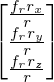

In [67]:
### 説明のためのブロックです。実際の計算ではここを実行する必要はありません。

from sympy import *
# おまじない
init_printing()

# f(r)をベクトルrで微分する。
f_r, r_x, r_y, r_z = symbols('f_r, r_x, r_y, r_z')
r = Matrix(3,1,[r_x,r_y,r_z])
r_2 = r_x**2 + r_y**2 + r_z**2
D = diff(sqrt(r_2), r) * f_r
Di = D.subs((r_x**2+r_y**2+r_z**2)**0.5,'r')
Di

##### 二階微分

$${\partial^2 \phi\over \partial x_i\partial x_j}={\partial\over\partial x_j}\left({\partial r\over\partial  x_i}\cdot{\partial \phi\over \partial r}\right)$$
$$={\partial^2 r\over\partial  x_i\partial  x_j}\cdot{\partial \phi\over \partial r}+{\partial r\over\partial  x_i}\cdot\left({\partial\over\partial x_j}{\partial \phi\over \partial r}\right)$$
$$={\partial^2 r\over\partial  x_i\partial  x_j}\cdot\phi_r-{r_x\over r}\cdot{r_x\over r}\phi_{rr}$$

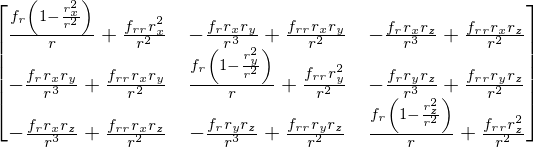

In [69]:
### 説明のためのブロックです。実際の計算ではここを実行する必要はありません。

# f(r)をベクトルrで2回微分する。
f_rr = symbols('f_rr')
Dii = Matrix(3,3,diff(sqrt(r_2), r.T, r) * f_r)          # first term
Dii += diff(sqrt(r_2), r) * diff(sqrt(r_2), r).T * f_rr  # second term
Dii = Dii.subs((r_x**2+r_y**2+r_z**2)**0.5,'r')          # simplify
Dii

#### 実装

`phis`はサイトサイト間相互作用と、それの距離による多階微分を含む辞書であり、下の`derivatives()`関数で計算される、

また、切断関数$T$についてはここには詳しく書かないが、$\phi\cdot T$のHessianの計算には$T$の高階微分が含まれるので、かなり面倒。導出は`DerivTrunc.ipynb`を参照。

In [92]:
# 剛体対ヘシアン

def Hessian_tt(ints, seps, phis, v, vL, ramp, ramp_r, ramp_rr, Tv, Tvv):
    """
    Trans-Trans Hessian for a pair of molecules
    """
    H = np.zeros([3,3])
    
    for si,sj in zip(*np.where(ints)):
        r = seps[si,sj]
        phi, phi_r, phi_rr = phis[si,sj]
        h = dii(r, phi_r, phi_rr)
        # print("sdxx",si,sj,h[0,0]/0.52**2)
        # print("ri",1/np.linalg.norm(r))
        if ramp<1.0:
            #print("ramp",ramp, Tvv)
            # print(v, vL, ramp, ramp_r, ramp_rr, Tv, Tvv)
            rL = np.linalg.norm(r)
            h = ramp*h + Tvv*phi
            h += ramp_r*phi_r/(vL*rL) * (np.outer(r,v)+np.outer(v,r))
            # print("OUTER",(np.outer(r,v)+np.outer(v,r))/(vL*rL))
        H += h
    Htt = np.zeros([2,3,2,3], dtype=float)
    Htt[0, :, 0, :] = H
    Htt[1, :, 1, :] = H
    Htt[0, :, 1, :] = -H
    Htt[1, :, 0, :] = -H
    # print(Htt)
    return Htt

### 回転-回転ヘシアン

$h_{rr}(i,j)$は分子$i$と分子$j$の相互作用$\phi(i,j)$を、分子$i$または分子$j$の角度変数$\mathbf{\theta}=\{a_i,b_i,c_i,a_j,b_j,c_j\}$の2つで微分したものを要素とする、$6\times 6$行列である。

(下の関数`Hessian_rr`がこれにあたる。)


#### 式展開

##### 一階微分

サイト間相互作用$\phi$を分子$i$のオイラー角$a_i$で微分する。

$${\partial\phi\over\partial a_i}={\partial\phi\over\partial r}\cdot{\partial r\over\partial a_i}$$

$r$はサイト間距離。$\mathbf{r}$をサイト間相対位置ベクトルとすると、

$${\partial r\over\partial a_i}={\partial r\over\partial\mathbf{r}}\cdot{\partial \mathbf{r}\over\partial a_i}={\mathbf{r}\over r}\cdot{\partial \mathbf{r}\over\partial a_i}$$

$${\partial \mathbf{r}\over\partial a_i}={\partial \mathbf{R}_i\over \partial a_i}\cdot \mathbf{w}_k$$

${\partial \mathbf{R}_i\over \partial a_i}\cdot \mathbf{w}_k$を$\mathbf{s}_a$と書く。最終的に、

$${\partial\phi\over\partial a_i}=\phi_r\cdot {\mathbf{r}\over r}\cdot\mathbf{s}_a$$



##### 二階微分

サイト間相互作用$\phi$を分子$i$のオイラー角$a_i$と分子$j$のオイラー角$b_j$で微分する。

$${\partial^2\phi\over\partial a_i\partial b_j}={\partial\phi\over\partial r}\cdot{\partial\over\partial b_j}{\partial r\over\partial a_i}+{\partial\over\partial b_j}{\partial\phi\over\partial r}\cdot{\partial r\over\partial a_i}$$
$$=\phi_r\cdot{\partial^2 r\over\partial a_i\partial b_j}+{\partial r\over\partial b_j}{\partial r\over\partial a_i}\phi_{rr}$$

${\partial \mathbf{R}_i\over \partial b_j}\cdot \mathbf{w}_l$を$\mathbf{t}_b$と書くと、

$${\partial^2\phi\over\partial a_i\partial b_j}=\phi_r\cdot{\partial^2 r\over\partial a_i\partial b_j}+\left({\mathbf{r}\over r}\cdot \mathbf{s}_a\right)\left({\mathbf{r}\over r}\cdot \mathbf{t}_b\right)\phi_{rr}$$


#### 実装

分子$i$のベクトル${\partial \mathbf{R}_i\over \partial a_i}\cdot \mathbf{w}_k=\mathbf{s}_a$は下のコードでは`D1i[p,q,r]`である。
ただし、

* `p`は微分する$a_i$の軸(0〜2)
* `q`はベクトルの軸要素
* `r`はサイト番号(水なら0〜3)

分子$i$のベクトル${\partial^2 \mathbf{R}_i\over \partial a_i\partial b_i}\cdot \mathbf{w}_k=\mathbf{s}_a$は下のコードでは`D2i[p1,p2,q,r]`である。

* `p`は微分する$a_i$,$b_i$の軸(0〜2)
* `q`はベクトルの軸要素
* `r`はサイト番号(水なら0〜3)


In [93]:
def Hessian_rr(ints, seps, phis, D1i, D2i, D1j, D2j, ramp):
    """
    Rot-Rot Hessian for a pair of molecules
    """
    Hrr = np.zeros([2,3,2,3])
    for si,sj in zip(*np.where(ints)):
        r = seps[si,sj]
        phi, phi_r, phi_rr = phis[si,sj]

        rL = np.linalg.norm(r)

        # 式の導出はDerivative.ipynbを参照
        # **3 同じ分子の異なる角度変数の組みあわせ
        for d1 in range(3):
            for d2 in range(d1,3):
                h = (phi_r/rL**3*(rL**2 * (r @ D2i[d1,d2,:,si] + D1i[d1,:,si] @ D1i[d2,:,si]) -
                                                      (r @ D1i[d1,:,si])*(r @ D1i[d2,:,si])) +
                                         phi_rr/rL**2*(r @ D1i[d1,:,si])*(r @ D1i[d2,:,si]))
                Hrr[0,d1,0,d2] += h*ramp
                h = (phi_r/rL**3*(rL**2 * (-r @ D2j[d1,d2,:,sj] + D1j[d1,:,sj] @ D1j[d2,:,sj]) -
                                                      (r @ D1j[d1,:,sj])*(r @ D1j[d2,:,sj])) +
                                         phi_rr/rL**2*(r @ D1j[d1,:,sj])*(r @ D1j[d2,:,sj]))
                Hrr[1,d1,1,d2] += h*ramp
        # **4 異なる分子の角度変数の組みあわせ
        for id in range(3):
            for jd in range(3):
                h = -(phi_r/rL**3*(rL**2 * (D1i[id,:,si] @ D1j[jd,:,sj]) -
                                                       (r @ D1i[id,:,si])*(r @ D1j[jd,:,sj])) +
                                          phi_rr/rL**2*(r @ D1i[id,:,si])*(r @ D1j[jd,:,sj]))
                Hrr[0,id,1,jd] += h*ramp
        # 下半分はあとでコピー
    # Hrrを一旦3nmol x 3nmolの平たい上半行列に戻し、
    Hrr = Hrr.reshape(6,6)
    # 対称化し、
    Hrr = Hrr + Hrr.T - np.diag(Hrr.diagonal())
    # また行列の配列に戻す。
    Hrr = Hrr.reshape(2,3,2,3)
    return Hrr

### 並進-回転ヘシアン

$h_{tr}(i,j)$は分子$i$と分子$j$の相互作用$\phi(i,j)$を、分子$i$または分子$j$の角度変数$\mathbf{\theta}=\{a_i,b_i,c_i\}$と重心座標の2つで微分したものを要素とする、$6\times 6$行列である。

(下の関数`Hessian_tr`がこれにあたる。)

#### 式展開

##### 二階微分

$${\partial^2 \phi\over \partial x_i\partial a_j}={\partial^2 r\over\partial x_i\partial a_j}\cdot{\partial \phi\over \partial r}+{\partial r\over\partial  x_i}\cdot{\partial\over\partial a_j}{\partial \phi\over \partial r}$$
$$={\partial^2 r\over\partial x_i\partial a_j}\cdot\phi_r+{\partial r\over\partial  x_i}\cdot{\partial r\over\partial a_j} \phi_{rr}$$
$$={\partial^2 r\over\partial x_i\partial a_j}\cdot\phi_r+{r_x\over r}\cdot\left({\mathbf{r}\over r}\cdot \mathbf{t}_a\right)\phi_{rr}$$

$${\partial^2 r\over\partial x_i\partial a_i}={\partial \over \partial x_i}{\partial r\over \partial a_j}$$
$$={\partial \over \partial x_i}{\mathbf{r}\over r}\mathbf{t}_a$$
$$={\partial \over \partial x_i}\left({1\over r}(r_xt_{ax}+r_yt_{ay}+r_zt_{az})\right)$$
$$={\partial r\over \partial x_i} {-1\over r^2} \mathbf{r}\cdot\mathbf{t}_a + {1\over r}\cdot t_{ax}$$
$$={-r_x\over r^3} \mathbf{r}\cdot\mathbf{t}_a + {t_{ax}\over r} $$

#### 実装


In [94]:
def Hessian_tr(ints, seps, phis, D1i, D1j, ramp, Tv):
    """
    Trans-Rot Hessian for a pair of molecules
    """
    Htr = np.zeros([2,3,2,3])
    for si,sj in zip(*np.where(ints)):
        r = seps[si,sj]
        phi, phi_r, phi_rr = phis[si,sj]

        rL = np.linalg.norm(r)

        # **5 同じ分子
        for it in range(3):
            for ir in range(3):
                h = (phi_r/rL**3 * (rL**2*D1i[ir,it,si] - r[it]*(r @ D1i[ir,:,si])) +
                                          phi_rr/rL**2 * r[it]*(r @ D1i[ir,:,si]))
                if ramp != 1.0:
                    h = ramp*h + Tv[it]*phi_r/rL*(r @ D1i[ir,:,si])
                Htr[0,it,0,ir] += h
        for jt in range(3):
            for jr in range(3):
                h = (phi_r/rL**3 * (rL**2*D1j[jr,jt,sj] - r[jt]*(r @ D1j[jr,:,sj])) +
                                          phi_rr/rL**2 * r[jt]*(r @ D1j[jr,:,sj]))
                if ramp != 1.0:
                    h = ramp*h + Tv[jt]*phi_r/rL*(r @ D1j[jr,:,sj])
                Htr[1,jt,1,jr] += h
        # **6 異なる分子
        for it in range(3):
            for jr in range(3):
                h = (phi_r/rL**3 * (rL**2*D1j[jr,it,sj] - r[it]*(r @ D1j[jr,:,sj])) +
                                          phi_rr/rL**2 * r[it]*(r @ D1j[jr,:,sj]))
                if ramp != 1.0:
                    h = ramp*h + Tv[it]*phi_r/rL*(r @ D1j[jr,:,sj])
                Htr[0,it,1,jr] -= h
        for jt in range(3):
            for ir in range(3):
                h = (phi_r/rL**3 * (rL**2*D1i[ir,jt,si] + r[jt]*(-r @ D1i[ir,:,si])) +
                                          phi_rr/rL**2 * -r[jt]*(-r @ D1i[ir,:,si]))
                if ramp != 1.0:
                    h = ramp*h + Tv[jt]*phi_r/rL*(r @ D1i[ir,:,si])
                Htr[1,jt,0,ir] -= h
    return Htr

## 全ヘシアンの算出

基本的には、対ヘシアンを大きな行列に蓄えていくだけ。

混合物を扱う場合には、D0、D1、D2を2種類準備する必要があるが、基本的な構造はこれで対応できる。

In [97]:
## Hessianの計算。もっと小さい関数に分けたいが、かなり手強い。

def Hessians(pos, cell, D0, D1, D2, CCpairs, LJpairs, Trunc, Trunc_r, Trunc_rr, Rin, Transition):
    nmol = pos.shape[0]
    # 3x3行列の配列。
    Htt = np.zeros([nmol, 3, nmol, 3])
    Hrr = np.zeros([nmol, 3, nmol, 3])
    Htr = np.zeros([nmol, 3, nmol, 3])
    ep = 0
    
    celli = np.linalg.inv(cell)
    for im in range(nmol):
        for jm in range(im+1,nmol):
            # 重心間相対ベクトル
            v = pos[im][:3] - pos[jm][:3]
            # 周期境界条件
            v -= cell @ np.floor( celli @ v + 0.5 )
            # 重心間距離
            vL = np.linalg.norm(v)
            # print("vL",vL)

            # 切断関数を準備。
            trunc = False
            if vL > Rin + Transition:
                # 遠すぎる対はパス
                continue
            if vL > Rin:
                # カットオフ関数がかかる場合
                ramp = Trunc(vL, Rin, Transition)
                ramp_r = Trunc_r(vL, Rin, Transition)
                ramp_rr = Trunc_rr(vL, Rin, Transition)
                # Tのvによる一階微分(ベクトル)
                Tv = di(v, ramp_r)
                # Truncのvによる二階微分(テンソル)
                Tvv = dii(v, ramp_r, ramp_rr)
                trunc = v, vL, ramp, ramp_r, ramp_rr, Tv, Tvv
            else:
                # 近距離
                ramp = 1.0
                ramp_r = 0.0
                ramp_rr = 0.0
                Tv = None
                Tvv = None

            # サイト間の相互作用関数の、相対位置ベクトルによる多階微分をあらかじめ配列phisに入れておく。
            ints, seps, phis = derivatives(CCpairs, LJpairs, v, D0[im], D0[jm])

            # Check EP again
            ep += E_pair(ints, phis, ramp)

            # 並進・並進
            Htt0 = Hessian_tt(ints, seps, phis, v, vL, ramp, ramp_r, ramp_rr, Tv, Tvv)
            Htt[im, :, im, :] += Htt0[0, : , 0, :]
            Htt[jm, :, jm, :] += Htt0[1, : , 1, :]
            Htt[im, :, jm, :] += Htt0[0, : , 1, :]
            Htt[jm, :, im, :] += Htt0[1, : , 0, :]

            # 次は回転・回転
            Hrr0 = Hessian_rr(ints, seps, phis, D1[im], D2[im], D1[jm], D2[jm], ramp)
            Hrr[im, :, im, :] += Hrr0[0, : , 0, :]
            Hrr[jm, :, jm, :] += Hrr0[1, : , 1, :]
            Hrr[im, :, jm, :] += Hrr0[0, : , 1, :]
            Hrr[jm, :, im, :] += Hrr0[1, : , 0, :]

            # 最後に並進・回転
            Htr0 = Hessian_tr(ints, seps, phis, D1[im], D1[jm], ramp, Tv)
            Htr[im, :, im, :] += Htr0[0, : , 0, :]
            Htr[jm, :, jm, :] += Htr0[1, : , 1, :]
            Htr[im, :, jm, :] += Htr0[0, : , 1, :]
            Htr[jm, :, im, :] += Htr0[1, : , 0, :]
            
    return Htt, Hrr, Htr, ep

In [98]:
Htt, Hrr, Htr, ep = Hessians(pos, cell, D0, D1, D2, CCpairs, LJpairs, Trunc, Trunc_r, Trunc_rr, Rin=6.5, Transition=2.0)

nmol = pos.shape[0]
print("energy (kJ/mol)=",ep*TokJmol/nmol)

# 系が小さい場合には、圧倒的にここが遅い。
# numbaで2.5倍にはなる。まあ、速さが必要な部分はコンパイラで書くしかないだろう。今はいい。

energy (kJ/mol)= 0.03884210006882523


In [99]:
# np.set_printoptions(4)


wm = np.sum(mass)

# ***1 謎のテンソルの計算
eival = np.zeros([nmol,3])
eivec = np.zeros([nmol,3,3])

for i in range(nmol):
    # 分子内座標での慣性テンソル
    if lc[i] == 0:
        Ii = IM / wm
    else:
        Ii = np.zeros(3)
        Ii[0] = IM[1]
        Ii[1] = IM[2]
        Ii[2] = IM[0]   
        Ii /= wm
        
# wmで割ることで、並進には質量を掛ける必要がなくなる。
# verified rix, riy,riz

    ea,eb,ec = pos[i][3:6]
    # Pohorille, A., Pratt, L. R., LaViolette, R. A., Wilson, M. A. & MacElroy, R. D. Comparison of the structure of harmonic aqueous glasses and liquid water. J. Chem. Phys. 87, 6070–6077 (1998).
    # Goldstein Chap. 6
    ev = KETensor(ea, ec, Ii[0], Ii[1], Ii[2])
    print(ev)
    #print("***6")
    #print(ev)
    # ev verified
    ival, ivec = np.linalg.eig(ev)
    # sorted (unnecessary)
    #idx = np.argsort(-ival)
    #ival = ival[idx]
    #ivec = ivec[:,idx]
    # ival is diagonal elements of K_D
    # eival is K_D^{-1/2}
    eival[i] = 1/ival**0.5
    # Eigenvectors S
    eivec[i] = ivec
    # eig verified
    #print("eival")
    #print(eival[i])
    #print("eivec")
    #print(eivec[i])

# rot-rot
Hrr2 = np.zeros_like(Hrr)
for i in range(nmol):
    for j in range(nmol):
        # elements of rot-rot
        t = Hrr[j,:,i,:]
        # こっちはPohorilleの通り。
        t = eivec[j].T @ t @ eivec[i]
        sd = t * np.outer(eival[j],eival[i])
        Hrr2[j,:,i,:] = sd

# rot-trans
Htr2 = np.zeros_like(Htr)
for i in range(nmol):
    for j in range(nmol):
        # elements of trans-rot
        # こっちは記述がない。
        t = Htr[i,:,j,:]
        t = t @ eivec[j]
        sd = t * eival[j]
        Htr2[i,:,j,:] = sd

hess = np.zeros([6*nmol, 6*nmol])
hess[0*nmol:3*nmol,0*nmol:3*nmol] = Htt.reshape(3*nmol,3*nmol)
hess[3*nmol:6*nmol,3*nmol:6*nmol] = Hrr2.reshape(3*nmol,3*nmol)
hess[0*nmol:3*nmol,3*nmol:6*nmol] = Htr2.reshape(3*nmol,3*nmol)
hess[3*nmol:6*nmol,0*nmol:3*nmol] = Htr2.reshape(3*nmol,3*nmol).T

np.set_printoptions(4)



[[ 0.0633  0.003   0.    ]
 [ 0.003   0.0392 -0.0275]
 [ 0.     -0.0275  0.0976]]
[[0.0496 0.0145 0.    ]
 [0.0145 0.0504 0.0219]
 [0.     0.0219 0.0976]]


In [100]:
ival, ivec = np.linalg.eigh(hess)

In [101]:
ivs = []
for iv in sorted(ival,reverse=True):
    if iv > 0:
        iv = iv**0.5 * sw
    else:
        iv = -(-iv)**0.5 * sw
    ivs.append(iv)

print(ivs)

[87.73244799022658, 42.282076381932136, 38.04740508790319, 0.9474540756462239, 2.7138407455199093e-07, -4.353907683626431e-07, -5.339548777111807e-07, -6.874400589814652, -31.45830856875844, -35.21889014978632, -58.68442554728475, -86.01091288244517]


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-72.4872, -70.8106, -69.1339, -67.4572, -65.7805, -64.1039,
        -62.4272, -60.7505, -59.0738, -57.3972, -55.7205, -54.0438,
        -52.3672, -50.6905, -49.0138, -47.3371, -45.6605, -43.9838,
        -42.3071, -40.6304, -38.9538, -37.2771, -35.6004, -33.9237,
        -32.2471, -30.5704, -28.8937, -27.2171, -25.5404, -23.8637,
        -22.187 , -20.5104, -18.8337, -17.157 , -15.4803, -13.8037,
        -12.127 , -10.4503,  -8.7736,  -7.097 ,  -5.4203,  -3.7436,
         -2.0669,  -0.3903,   1.2864,   2.9631,   4.6397,   6.3164,
      

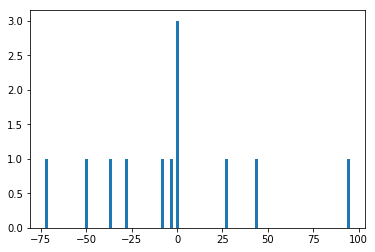

In [253]:
%matplotlib inline

from matplotlib import pyplot as pl

pl.hist(ivs, bins=100)


## 完了
* 第二回転規約
   * 全部第二規約にすると、全部第二規約とした田中プログラムと同じ答えになることを確認。
   * 一方で、田中プログラム自体、規準を変更すると振動数が変わるのがとても気になる。
   * 回転行列を二種類準備する代わりに、分子内座標を2種類準備することにした。
     * xyz→yzxに変えるようにした。
     * 角度変換規則(euler_conv)は田中のものと結果的には同じであった。たぶん発想は同じ。
     * その場合でも、振動数が微妙に変化する。変化のしかたも同様なので、同じことをやっているにすぎないと思われる。
     * ということは、分子内座標で、分子をどういう向きに置くかによって、結果が変わるということ。
     * Hessianの計算に関しては、あまり疑う余地がないので、mass weightのあたりしか考えられないのだが…。
     * Quenchしてあれば問題がおきないということで合意。Quenchしない場合に変になる理由はわからない。
* LJ
* 多分子
* 周期境界条件
* Truncation
* 特殊な単位系の廃止
* 小さい系(CS2)であれば、現実的な速度で正確な振動を得ることができた。2019-09-26
* 整理し、読みやすくする。

## 未完

* numbaによる高速化
* Hessianの式の自動生成
* 多成分
* 直線分子
* 単原子分子
* qhaとの比較

## 別計画

* 数値微分によるHessian計算はどれぐらい現実味があるのか。
   * このプログラムがうまく動くことが確認できれば、比較対象に使える。 
